In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

converged SCF energy = -100.291327706251
TODO: total wave-function symmetry for Coov
occupancy for each irrep:     A1  E1x  E1y
                               3    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -24.2331671128069 occ= 2
MO #2 (A1 #2), energy= -1.0272972299461 occ= 2
MO #3 (A1 #3), energy= -0.42613119010555 occ= 2
MO #4 (E1x #1), energy= -0.289938520612844 occ= 2
MO #5 (E1y #1), energy= -0.289938520612842 occ= 2
MO #6 (A1 #4), energy= -0.0349559135896403 occ= 0
MO #7 (A1 #5), energy= 0.664675049298747 occ= 0
MO #8 (E1x #2), energy= 1.1305709354121 occ= 0
MO #9 (E1y #2), energy= 1.1305709354121 occ= 0
MO #10 (A1 #6), energy= 1.24759809513673 occ= 0
MO #11 (A1 #7), energy= 1.57280313485609 occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.35670
charge of  1F =     -0.35670
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000, -2.17040
Total dft energy: -100.29132770625064
Chemical Potential:  -0.1624472171012411
DFT trace:  7.124009715257133


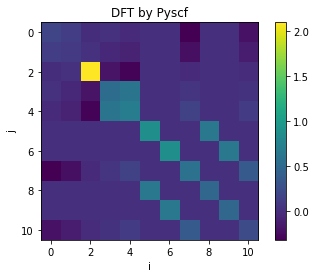

In [2]:
'''
A simple example to run DFT calculation.
'''

# PBE Hydrogen flouride in a 6-31G basis set.
mol = gto.Mole()
mol.build(
    atom = 'H 0 0 0; F 0 0 1.1',  # in Angstrom
    basis = '631g',
    symmetry = True,
)

mf = dft.RKS(mol)
#mf.xc = 'blyp' # shorthand for b88,lyp
mf.xc = 'pbe' # shorthand for pbe,pbe
#mf.xc = 'lda,vwn_rpa'
#mf.xc = 'pbe0'
#mf.xc = 'b3lyp'

# this where self-content diagonalization happens
mf.kernel()

# Orbital energies, Mulliken population etc.
mf.analyze()

# Get the converged density matrix (it generates the density matrix)
dm = mf.make_rdm1()
mmwrite('dft_density.mtx', sparse.coo_matrix(dm))


# Get the nuclear-nuclear repulsion energy
e_nuc = mf.energy_nuc()
# Get the 'core' hamiltonian, corresponding to kinetic energy and e-nuclear repulsion terms
h1e = mf.get_hcore()
#mmwrite('dft_hcore.mtx', sparse.coo_matrix(h1e))
e1 = np.einsum('ij,ji', h1e, dm) # Compute the kinetic + e-nuclear repulsion energy
# Get the kohn-sham potential, including the Hartree coulomb repulsion and exchange-correlation potential, integrated on a grid
vhf = mf.get_veff(mf.mol, dm)
#print(type(vhf))
#print(vhf)
# Total energy
tot_e = e1 + vhf.ecoul + vhf.exc + e_nuc    # Total energy is sum of terms
print('Total dft energy: {}'.format(tot_e))

# chemical potential
index = int(mol.nelectron/2)
mu = (mf.mo_energy[index] + mf.mo_energy[index - 1]) / 2.
dft_mu = mu
print('Chemical Potential: ', str(mu))

# get the overlap matrix and print to file
ovlp = mf.get_ovlp()
#mmwrite('dft_overlap.mtx', sparse.coo_matrix(ovlp))

# Full fock matrix is sum of h1e and vhf
fock = h1e + vhf

# Get whole fock matrix directly corresponding to this density, without computing individual components
fock_direct = mf.get_fock(dm=dm)

# Check that ways to get the fock matrix are the same
assert(np.allclose(fock_direct,fock))

print("DFT trace: ", dm.trace())

plt.imshow(dm.real)
plt.title("DFT by Pyscf")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

NTPoly Trace:  4.015391362234546


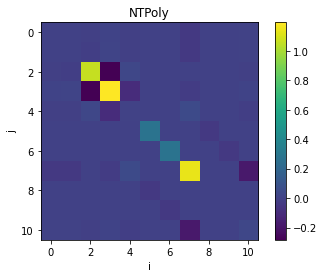

In [3]:
ntpoly_rho = nt.NTPoly_cp(h1e, ovlp, int(dm.trace()))
print("NTPoly Trace: ", ntpoly_rho.trace())

plt.imshow(ntpoly_rho.real)
plt.title("NTPoly")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

GCP steps:  14
Palser GCP trace:  (4.999999999999999+0j)
CP steps:  23
Palser CP trace:  (7.124009715257121+0j)


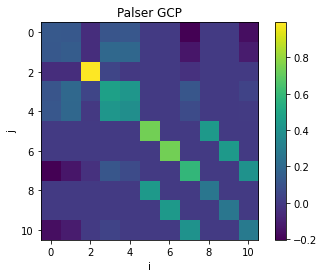

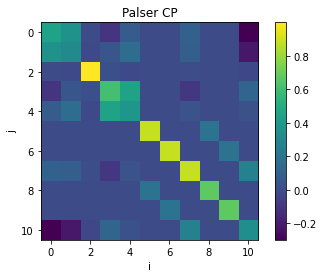

In [4]:
# Palser solver
better_mu = -10
palser_gcp_rho = pals.gcp(better_mu, h1e, 1000)
print("Palser GCP trace: ", palser_gcp_rho.trace())
palser_cp_rho = pals.cp(dm.trace(), h1e, 1000)
print("Palser CP trace: ", palser_cp_rho.trace())

plt.figure(1)
plt.imshow(palser_gcp_rho.real)
plt.title("Palser GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(palser_cp_rho.real)
plt.title("Palser CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

DMM GCP trace:  10.999999999999998
DMM CP trace:  11.000000000000002


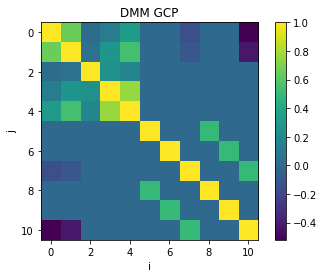

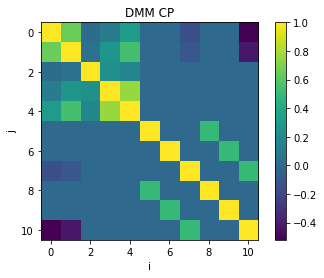

In [5]:
# DMM Solvers
dbeta = 0.003
num_electrons = 7

inv_ovlp = np.linalg.inv(ovlp)
init_rho = num_electrons/ovlp.trace() * ovlp
identity = np.identity(init_rho.shape[0])

dmm_gcp = gcp.rk4(gcp.rhs, init_rho.copy(), dbeta, h1e, inv_ovlp, identity, better_mu, 1000)
print("DMM GCP trace: ", dmm_gcp.trace())
dmm_cp = cp.rk4(cp.rhs, init_rho.copy(), dbeta, h1e, inv_ovlp, identity, 1000)
print("DMM CP trace: ", dmm_cp.trace())

plt.figure(1)
plt.imshow(dmm_gcp.real)
plt.title("DMM GCP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.imshow(dmm_cp.real)
plt.title("DMM CP")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

Iterations converged!
Iterations converged!


Text(0, 0.5, '||p_n+1 - p_n||')

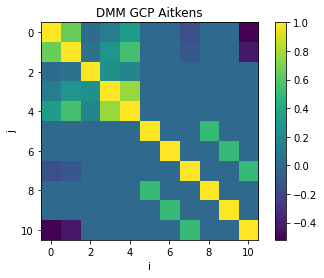

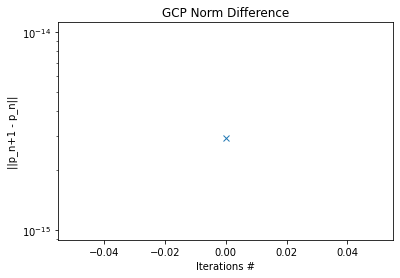

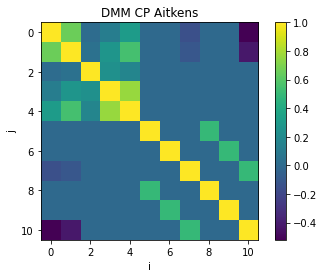

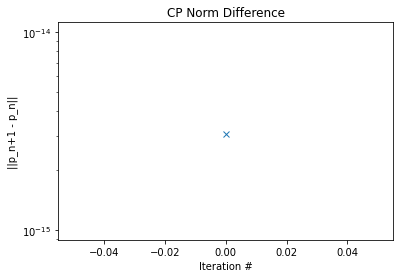

In [6]:
# Perform Aitkens convergence method on DMM methods
func_args = {'h1e': h1e, 'mf': mf, 'mu': better_mu, 'inv_ovlp': inv_ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
gcp_aitkens_rho, norm_diff = gcp.aitkens(dmm_gcp, 50, gcp.single_step, **func_args)

plt.figure(1)
plt.imshow(gcp_aitkens_rho)
plt.title("DMM GCP Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, 'x-')
plt.title("GCP Norm Difference")
plt.xlabel("Iterations #")
plt.ylabel("||p_n+1 - p_n||")

func_args = {'h1e': h1e, 'mf': mf, 'inv_ovlp': inv_ovlp, 'dbeta': dbeta, 'rk4steps': 1000}
cp_aitkens_rho, norm_diff = gcp.aitkens(dmm_cp, 20, cp.single_step, **func_args)

plt.figure(3)
plt.imshow(cp_aitkens_rho)
plt.title("DMM CP Aitkens")
plt.xlabel("i")
plt.ylabel("j")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, 'x-')
plt.title("CP Norm Difference")
plt.xlabel("Iteration #")
plt.ylabel("||p_n+1 - p_n||")

funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 0.9336492121326924
funm result may be inaccurate, approximate err = 3.916624432893964e-05
funm result may be inaccurate, approximate err = 0.00012025179674807569
funm result may be inaccurate, approximate err = 0.03361144991007084
funm result may be inaccurate, approximate err = 0.03134598906061438
funm result may be inaccurate, approximate err = 0.626911434759728
funm result may be inaccurate, approximate err = 0.07780976092043485
funm result may be inaccurate, approximate err = 0.8386165864311207
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 1
funm result may be inaccurate, approximate err = 4.40940555404571e-12
funm result may be inaccurate, approximate err = 8.787818331086181e-12
funm result may be inaccurate, approximate err = 2.214651691494843e-09
funm result may be inaccurate, 

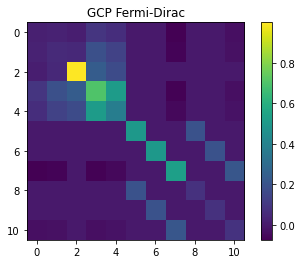

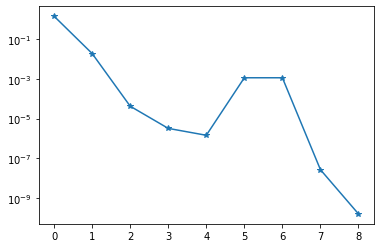

In [7]:
func_args = {'h1e': h1e, 'mf': mf, 'mu': better_mu, 'inv_ovlp': inv_ovlp, 'beta': 1000*dbeta, 'ovlp': ovlp}
gcp_exact = ovlp @  linalg.funm(inv_ovlp @ h1e, lambda _: 1/(1+np.exp(func_args['beta']*(_ - better_mu))))

gcp_aitkens_rho, norm_diff = gcp.aitkens(gcp_exact, 50, gcp.exact_single_step, **func_args)
plt.imshow(gcp_exact.real)
plt.title("GCP Fermi-Dirac")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')

Iterations converged!


'\nsteady_gcp_aitkens2, norm_diff = gcp.aitkens(init_rho.copy(), 50, gcp.steady_single_step, func_args)\nplt.figure(3)\nplt.imshow(steady_gcp_aitkens2.real)\nplt.title("Steady State from Initial P")\nplt.colorbar()\n\nplt.figure(4)\nplt.semilogy(norm_diff, \'*-\')\nplt.title("Convergence")\nplt.xlabel("Iteration #")\n'

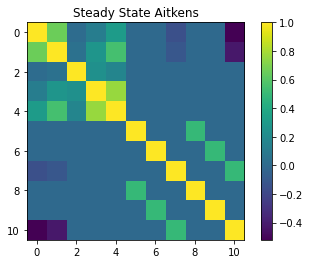

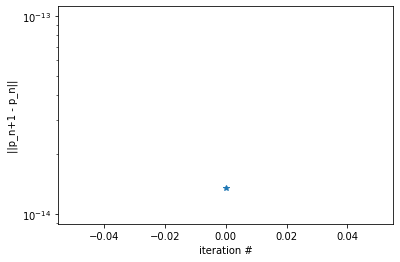

In [8]:
steady_gcp_aitkens, norm_diff = gcp.aitkens(dmm_gcp.copy(), 50, gcp.steady_single_step, **func_args)
plt.figure(1)
plt.imshow(steady_gcp_aitkens.real)
plt.title("Steady State Aitkens")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.xlabel("iteration #")
plt.ylabel("||p_n+1 - p_n||")

"""
steady_gcp_aitkens2, norm_diff = gcp.aitkens(init_rho.copy(), 50, gcp.steady_single_step, func_args)
plt.figure(3)
plt.imshow(steady_gcp_aitkens2.real)
plt.title("Steady State from Initial P")
plt.colorbar()

plt.figure(4)
plt.semilogy(norm_diff, '*-')
plt.title("Convergence")
plt.xlabel("Iteration #")
"""

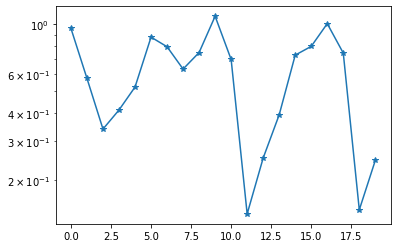

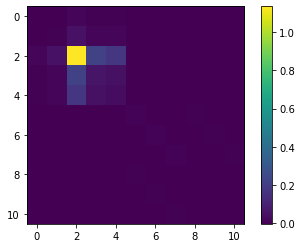

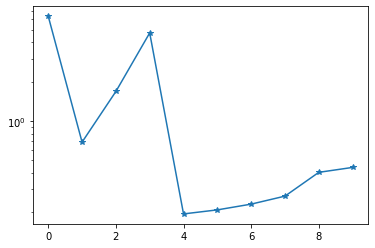

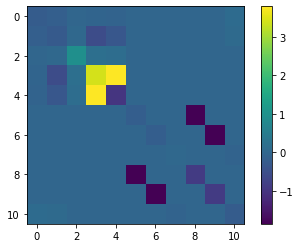

In [9]:
func_args = {'h1e':h1e, 'mu': better_mu, 'inv_ovlp': inv_ovlp, 'mf': mf}
rho = ovlp.copy()/2
    
norm_diff = []
for i in range(20): 
    rho_next = gcp.steady_single_step(rho, **func_args)
    norm_diff.append(linalg.norm(rho_next - rho))
    rho = rho_next
    if norm_diff[-1] < 1e-10:
        break
plt.figure(1)
plt.semilogy(norm_diff, '*-')

plt.figure(2)
plt.imshow(rho.real)
plt.colorbar()      


temp, temp_norm = gcp.aitkens(ovlp.copy()/2, 10, gcp.steady_single_step, **func_args)
'''
for i in range(2):
    temp_sq = temp @ inv_ovlp @ temp
    temp_cu = temp_sq @ inv_ovlp @ temp
    
    temp = 3*temp_sq - 2*temp_cu
'''
plt.figure(3)
plt.semilogy(temp_norm, '*-')

plt.figure(4)
plt.imshow(temp.real)
plt.colorbar()

In [10]:
en = (h1e + mf.get_veff(mf.mol, temp))@temp
en = en.trace()

In [11]:
en

-65.17788379118355

In [12]:
norm_rho = rho / num_electrons
print(linalg.norm(norm_rho @ norm_rho - norm_rho))
print(norm_rho.trace())

0.14308963525072235
0.18023885662974562


In [13]:
norm_dm = dm / num_electrons
print(linalg.norm(norm_dm @ norm_dm - norm_dm))
print(norm_dm.trace())

0.3616080638691335
1.0177156736081618


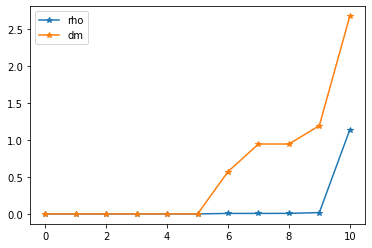

In [14]:
plt.plot(linalg.eigvalsh(rho, ovlp), '-*', label='rho')
plt.plot(linalg.eigvalsh(dm, ovlp), '-*', label='dm')
plt.legend()

In [15]:
num_electrons

7

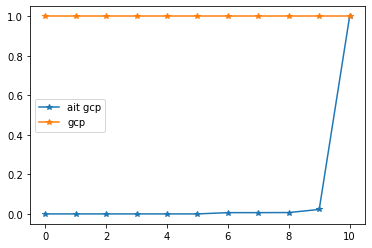

In [16]:
plt.plot(linalg.eigvalsh(gcp_aitkens_rho, ovlp), '*-', label='ait gcp')
plt.plot(linalg.eigvalsh(dmm_gcp, ovlp), '*-', label='gcp')
plt.legend()

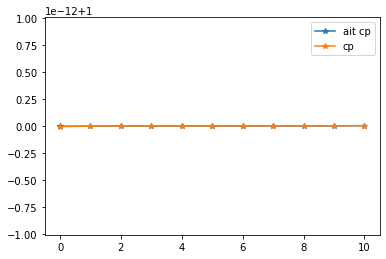

In [17]:
plt.plot(linalg.eigvalsh(cp_aitkens_rho, ovlp), '*-', label='ait cp')
plt.plot(linalg.eigvalsh(dmm_cp, ovlp), '*-', label='cp')
plt.legend()

In [18]:
dmm_cp.trace()

11.000000000000002

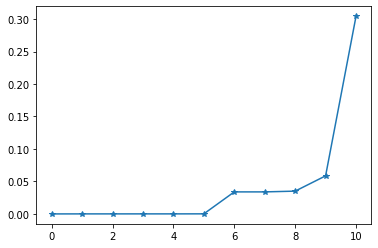

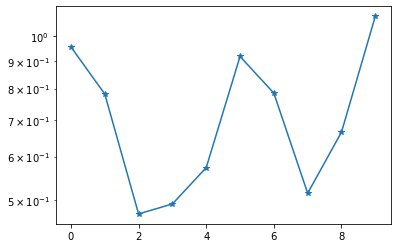

In [19]:
rho = num_electrons/ovlp.trace() * ovlp
func_args['mu'] = better_mu
norm_list = []
for i in range(10):
    next_rho = gcp.steady_single_step(rho, **func_args)
    norm_list.append(linalg.norm(next_rho - rho))
    rho = next_rho.copy()
    
    if norm_list[-1] < 1e-10:
        break
        
plt.plot(linalg.eigvalsh(rho, ovlp), '*-')
plt.figure(2)
plt.semilogy(norm_list, '*-')

In [20]:
rho.trace()

0.5446461985114905

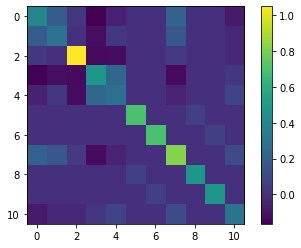

In [23]:
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.003
iden = np.identity(rho_i.shape[0])
mu = dft_mu
for i in range(1000):
    H = h1e + mf.get_veff(mf.mol, rho_i)
    B = inv_ovlp @ H
    B += B.conj().T
    B/= 2
    
    A = inv_ovlp @ rho_i
    A += A.conj().T
    A /= 2
    
    K = -dbeta/2 * (iden - A) @ (B - mu*iden)
    Kdag = -dbeta/2 * (B - mu*iden) @ (iden - A)
    
    rho_next = (iden + Kdag) @ rho_i @ (iden + K)
    herm_check.append(linalg.norm(rho_next - rho_next.conj().T))
    trace_check.append(rho_next.trace())
    rho_i = rho_next
    
plt.imshow(rho_i.real)
plt.colorbar()

Text(0.5, 1.0, 'Norm Diff of Steady State')

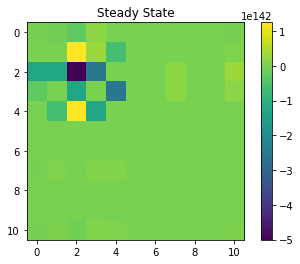

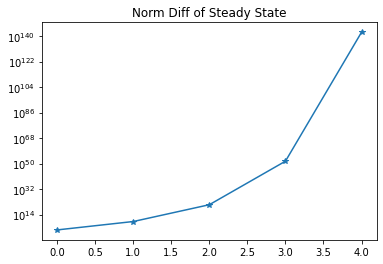

In [22]:
# Steady state
rho_i = init_rho.copy()
herm_check = []
trace_check = []
trace_check.append(rho_i.trace())
dbeta = 0.003
iden = np.identity(rho_i.shape[0])
inv_ovlp = ovlp.copy()
B = inv_ovlp @ h1e
B += B.conj().T
B/= 2

norm_diff = []
for i in range(5):
    H = h1e + mf.get_veff(mf.mol, rho_i)
    B = inv_ovlp @ h1e
    B += B.conj().T
    B/= 2
    A = inv_ovlp @ rho_i
    A += A.conj().T
    A /= 2
    rho_next = (iden + B) @ rho_i @ (iden + B) - B @ rho_i @ B
    rho_next += B @ A @ rho_i @ A @ B - (iden + B @ A) @ rho_i @ (iden + A @ B)
    rho_next += mu * ((iden + A) @ rho_i @ (iden + A) - A @ rho_i @ A)
    rho_next /= (3*mu)
    
    norm_diff.append(linalg.norm(rho_next - rho_i))
    if norm_diff[-1] < 1e-16:
        break
    
    rho_i = rho_next.copy()

plt.figure(1)
plt.imshow(rho_i.real)
plt.title("Steady State")
plt.colorbar()

plt.figure(2)
plt.semilogy(norm_diff, '*-')
plt.title("Norm Diff of Steady State")